# Change in numbers of bike trips over time and the effect of user type on duration.

## By Ibrahim Mohamed

## Investigation Overview

In this investigation, I wanted to find the best months of the year, the best days of the week to have the largest number of bike rides. Also I want to see the relationship between user type and duration.

## Dataset Overview

This Notebook explores a dataset containing information about approximately 1.8M individual rides made in a bike-sharing system covering the greater San Francisco Bay area between (1/1/2018) => (31/12/2018). It includes start and end time, some information about start and end stations ( id, longitude, latitude, name), also there is a column for user type and bike id. ( I added some columns later ( distance, duration(min) ). at some point I removed some outlires that spent more than 160 minutes.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math
from datetime import datetime

%matplotlib inline

In [3]:
# Loading the first dataset.
bike_rides = pd.read_csv('201801-fordgobike-tripdata.csv')

# Connect the files together to get the full year data

for i in range(11):
    month = '0' + str(i+2) if i < 8 else str(i+2)
    file = '2018' + month + '-fordgobike-tripdata.csv'
    bike_rides = pd.concat([bike_rides, pd.read_csv(file)], ignore_index=True)

In [ ]:
#Correct the data type for both start and end time.
bike_rides['start_time'] = pd.to_datetime(bike_rides['start_time'])
bike_rides['end_time'] = pd.to_datetime(bike_rides['end_time'])

In [8]:
# Sorting records according to start_time column
bike_rides.sort_values(by=['start_time'], inplace = True)

In [10]:
# Creating a catigorical variable for months.
monNames = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun',
                7 : 'Jul', 8 : 'Aug', 9 : 'Seb', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}
def monName(date_):
    return monNames[date_.month]

bike_rides['Month'] = bike_rides.apply(lambda x : monName(x['start_time']), axis = 1)

## The change in numbers ( bike rides ) across the year.
The Month variable plotted on a bar plot, there is an increase in the first 6 months then numbers decreases in the rest of the year.

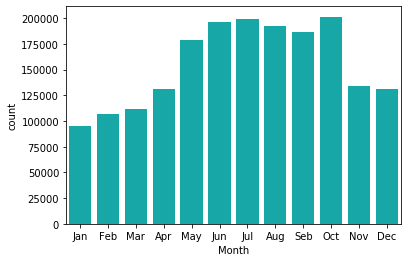

In [11]:
# Start with a bar plot to count the ride trips for each month.
sb.countplot(data = bike_rides, x = 'Month', color = 'c');

In [12]:
# Creating a catigorical variable for days.
dayNames = {1 : 'Sat', 2 : 'Sun', 3 : 'Mon', 4 : 'Tue',
                5 : 'Wed', 6 : 'Thu', 0 : 'Fri'}
days_to = {1 : 0, 2 : 31, 3 : 59, 4 : 90, 5 : 120, 6 : 151,
                7 : 181, 8 : 212, 9 : 243, 10 : 273, 11 : 304, 12 : 334}
def dayName(date_):
    return dayNames[(days_to[date_.month] + date_.day + 2) % 7]

bike_rides['Day'] = bike_rides.apply(lambda x : dayName(x['start_time']), axis = 1)

## The change in numbers ( bike rides ) by days.

The Day variable plotted in a bar plot, and it appeared that at the end of the week, the number of bike rides decreases.

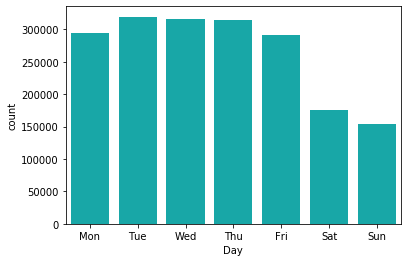

In [13]:
# Plotting a bar plot to see the number of trips per day of the week.
sb.countplot(data = bike_rides, x = 'Day', color = 'c');

## The distribution of duration.
On a standard scale, duration variable had a very long tail, then after plotting it on a logarithmic scale, the distribution looks extremely right skewed, and when using the duration(min) variable, it appeard that 99% of users don't spent more than 160 minutes in their trips.

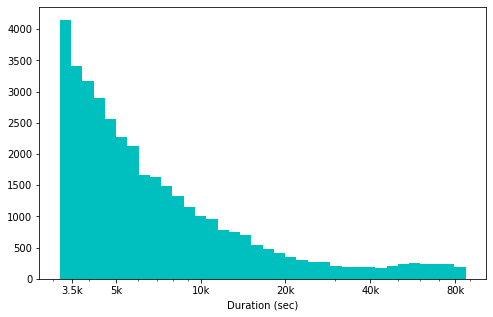

In [16]:
# There's a very long unclear tail in the distribution, so let's put it on a log scale instead.
log_bin_size = 0.04
bins = 10 ** np.arange(3.5, np.log10(bike_rides['duration_sec'].max()) + log_bin_size, log_bin_size)

plt.figure(figsize=[8, 5])
plt.hist(data = bike_rides, x = 'duration_sec', bins = bins, color = 'c')
plt.xscale('log')
plt.xticks([3.5e3, 5e3, 1e4, 2e4, 4e4, 8e4], ['3.5k', '5k', '10k', '20k', '40k', '80k'])
plt.xlabel('Duration (sec)');

In [ ]:
# Creating a column to calculate minutes out of seconds.
bike_rides['duration_min'] = bike_rides['duration_sec'] // 60

In [267]:
# Removing outliers (spent more than 160 minutes)
bike_rides = bike_rides[bike_rides['duration_min'] < 160]

## Comprasion between the two user types in duration (min).

This violin plot has a logarithmic y scale for duration (min), after removing outlires(>160 min) and it shows that on average customers spent more minutes in their bike trips.

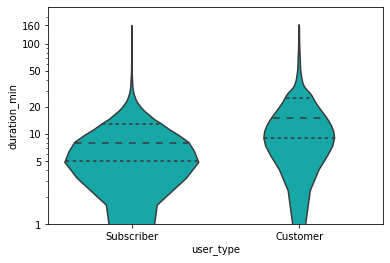

In [268]:
sb.violinplot(data = bike_rides, x = 'user_type',
              y = 'duration_min', color = 'c', inner = 'quartile')
plt.yscale('log')
plt.yticks([1, 5, 10, 20, 50, 100, 160], [1, 5, 10, 20, 50, 100, 160])
plt.ylim(1,);

## The change in average duration(min) over the year by user type.
This point plot shows that over the year, average duration for customers is always greater than average duration for subscribers. Also it appears that average duration is slightly decreasing for customers over the year, while it sounded constant as for subscribers.

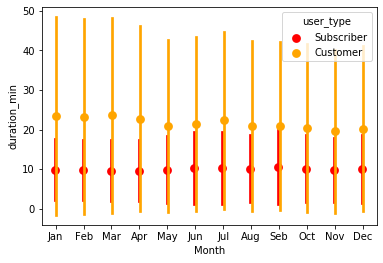

In [270]:
sb.pointplot(data = bike_rides, x = 'Month', y = 'duration_min', hue = 'user_type',
             palette = ['red', 'orange'], ci = 'sd', dodge = True, linestyles = '');

In [20]:
# Creating a distance variable using the coordinates.
def deg2rad(deg):
    return deg * (math.pi/180)

def getDistance(lat1,lon1,lat2,lon2):
    R = 6371
    dLat = deg2rad(lat2-lat1)
    dLon = deg2rad(lon2-lon1)
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(deg2rad(lat1)) * math.cos(deg2rad(lat2)) * math.sin(dLon/2) * math.sin(dLon/2)

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c #Distance in Km
    
    return d

bike_rides['distance'] = bike_rides.apply(lambda x: getDistance(x['start_station_latitude'], x['start_station_longitude'],
                                     x['end_station_latitude'], x['end_station_longitude']), axis = 1)

In [264]:
# Using plot matrix: sample 1000 rides.
samples = np.random.choice(bike_rides.shape[0], 1000, replace = False)
bike_rides_samp = bike_rides.loc[samples,:]

In [272]:
bike_rides_samp = bike_rides_samp[bike_rides_samp['duration_min'] < 160]

## Correlation between distance and duration(min) for each type of users.

After creating a distance(Km) using start and end stations coordinates. This scatter plot shows that both user types follow the same curve in the relation ship, between ( distance and duration), but it sounded that the ratio ( number of points > 30 min ) to (number of points for the whole type), is greater for customers which ensure the point that customers on average spent more minutes in their bike trips.

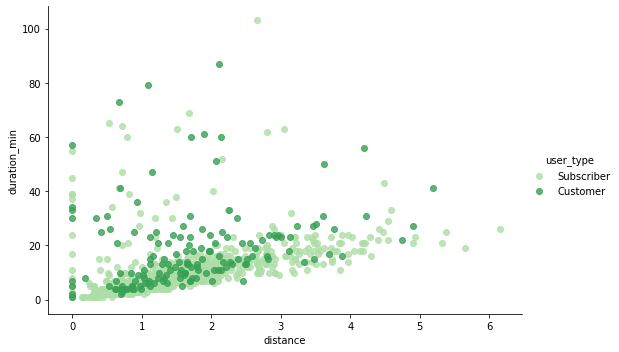

In [275]:
g = sb.FacetGrid(data = bike_rides_samp, hue = 'user_type', size = 5, aspect = 1.5, palette = 'Greens')
g = g.map(sb.regplot, 'distance', 'duration_min', fit_reg = False);
g.add_legend();

In [315]:
# Grouping by station name.
df = pd.DataFrame(bike_rides.groupby(['start_station_name'])['user_type'].value_counts())
df.rename(columns={'user_type': 'count'}, inplace = True)
df.reset_index(inplace=True)

In [316]:
# Grouping by the type (subscriber).
df2 = df.sort_values(by = ['count'])[df.sort_values(by = ['count'])['user_type'] == 'Subscriber']

In [320]:
# Grouping by the type (Customer).
df3 = df.sort_values(by = ['count'])[df.sort_values(by = ['count'])['user_type'] == 'Customer']

Getting dataframes with only top 5 stations for each user type.

In [339]:
top_sub = list(df2.tail(5)['start_station_name'])
top_sub

['Montgomery St BART Station (Market St at 2nd St)',
 'Berry St at 4th St',
 'Market St at 10th St',
 'San Francisco Caltrain (Townsend St at 4th St)',
 'San Francisco Caltrain Station 2  (Townsend St at 4th St)']

In [344]:
df_top_sub = bike_rides.query('start_station_name in ["Montgomery St BART Station (Market St at 2nd St)","Berry St at 4th St","Market St at 10th St","San Francisco Caltrain (Townsend St at 4th St)", "San Francisco Caltrain Station 2  (Townsend St at 4th St)"]')
df_top_sub.shape[0]

172949

In [345]:
top_cus = list(df3.tail(5)['start_station_name'])
top_cus

['The Embarcadero at Vallejo St',
 'Powell St BART Station (Market St at 5th St)',
 'Powell St BART Station (Market St at 4th St)',
 'San Francisco Ferry Building (Harry Bridges Plaza)',
 'The Embarcadero at Sansome St']

In [346]:
df_top_cus = bike_rides.query('start_station_name in ["The Embarcadero at Vallejo St", "Powell St BART Station (Market St at 5th St)", "Powell St BART Station (Market St at 4th St)", "San Francisco Ferry Building (Harry Bridges Plaza)", "The Embarcadero at Sansome St"]')
df_top_cus.shape[0]

137981

## Change in duration(min) over the year for top 5 stations for Subscribers.

In this point plot, it appeared that individually, stations don't have the same curve. Also the average minutes range in this plot is small (9 -12) minutes. ( Note that this average minutes is for the whole users in the station whatever the type, but these stations are the most stations to have Subscribers' bike rides). 

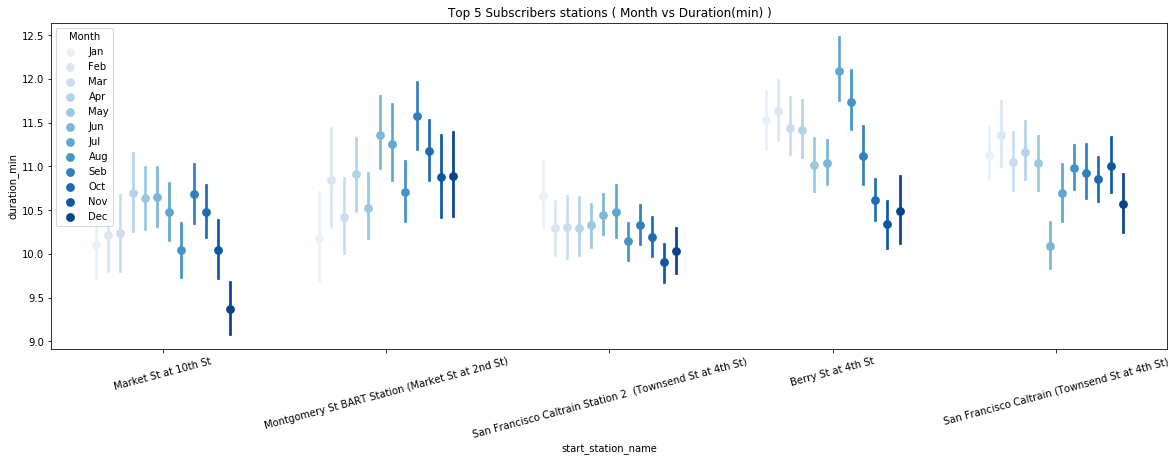

In [361]:
fig, ax = plt.subplots(ncols = 1, figsize = [20,6])

sb.pointplot(data = df_top_sub, x = 'start_station_name', y = 'duration_min', hue = 'Month',
             palette = 'Blues', linestyles = '', dodge = 0.6)
plt.xticks(rotation = 15)
plt.title('Top 5 Subscribers stations ( Month vs Duration(min) )');

## Change in duration(min) over the year for top 5 stations for Customers.

In this point plot, it appeared that individually, stations don't have the same curve. Also the average minutes range in this plot is high (10 - 20) minutes comparing to the previous plot for top 5 stations for Subscribers. ( Note that this average minutes is for the whole users in the station whatever the type, but these stations are the most stations to have Customers' bike rides). 

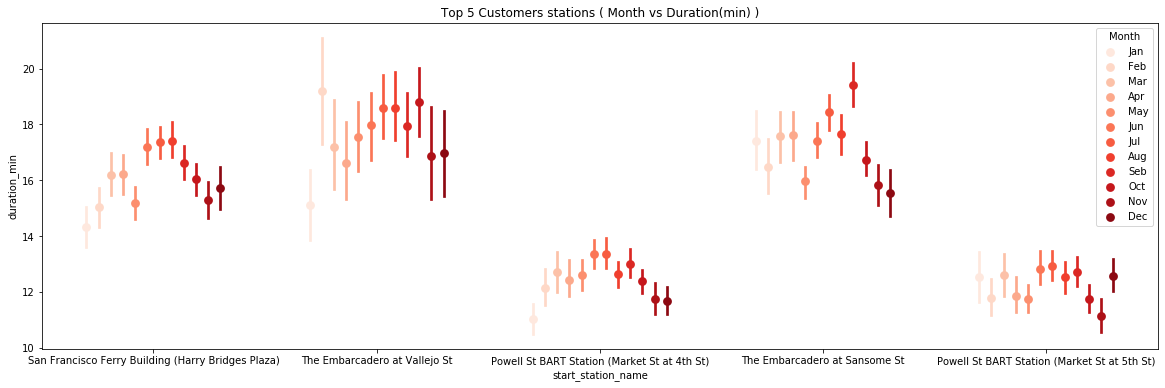

In [362]:
fig, ax = plt.subplots(ncols = 1, figsize = [20,6])
sb.pointplot(data = df_top_cus, x = 'start_station_name', y = 'duration_min', hue = 'Month',
             palette = 'Reds', linestyles = '', dodge = 0.6)
plt.title('Top 5 Customers stations ( Month vs Duration(min) )');